# Jake's exploration

In [57]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import json
import ast

In [8]:
df = pd.read_csv("ted_main.csv")
print df.dtypes

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
dtype: object


### Do the average number of views from related videos affect views on the video?

In [67]:
related_view = []
for idx, row in df.iterrows():
    view_m = re.findall('\'viewed_count\': [0-9]+', row.related_talks)
    total_views = 0
    num_related_vids = 0
    for v in view_m:
        vs = re.search('[0-9]+', v)
        num_related_vids += 1
        total_views += int(vs.group(0))
    related_view.append(total_views / num_related_vids)
df['avg_related_views'] = pd.Series(data=related_view, index=df.index)

print df.dtypes

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
avg_related_views      int64
num_related_vids       int64
dtype: object


#### Let's look at the distribution of views

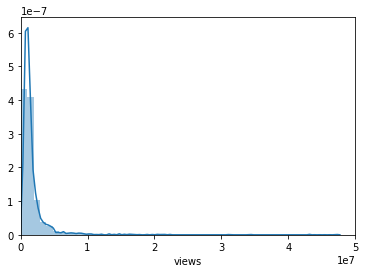

In [146]:
plt.xlim(0, 50000000)
sns.distplot(df.views)
plt.savefig('views_with_outliers.png')

#### There seem to be a lot of high outliers. Let's get rid of those...

In [73]:
q1_related = df["avg_related_views"].quantile(0.25)
q3_related = df["avg_related_views"].quantile(0.75)
q1 = df["views"].quantile(0.25)
q3 = df["views"].quantile(0.75)
no_outliers = [row.avg_related_views if row.avg_related_views < q3_related + (q3_related - q1_related) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [row.views if row.views < q3 + (q3 - q1) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [xaxis[idx] if not np.isnan(no_outliers[idx]) else np.nan for idx, row in df.iterrows()]
no_outliers = [no_outliers[idx] if not np.isnan(xaxis[idx]) else np.nan for idx, row in df.iterrows()]

for i in range(len(no_outliers)-1, -1, -1):
    if np.isnan(no_outliers[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

for i in range(len(xaxis)-1, -1, -1):
    if np.isnan(xaxis[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

no_outliers = pd.Series(data=no_outliers)
xaxis = pd.Series(data=xaxis)

line_kws={'color':'r', 'lw':1}
scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.3}



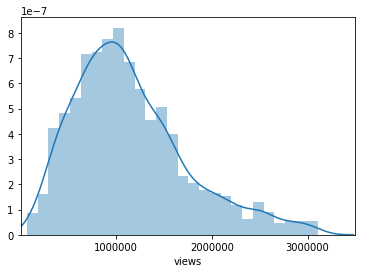

In [162]:
plt.xlim(0, 3500000)
plt.xticks([1e6, 2e6, 3e6])
sns.distplot(xaxis, axlabel="views")
plt.savefig('views_with_no_outliers.png')

#### This is roughly normal, but still skewed right.
#### Let's look at the distribution of the average related view count

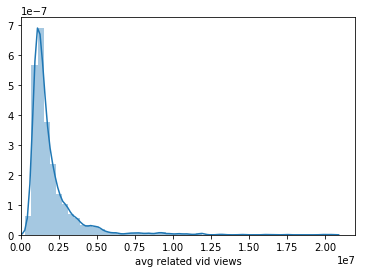

In [150]:
plt.xlim(0, 22000000)
sns.distplot(df.avg_related_views, axlabel="avg related vid views")
plt.savefig('avg_related_vid_views_outliers.png')

#### This also seems to have a lot of high outliers

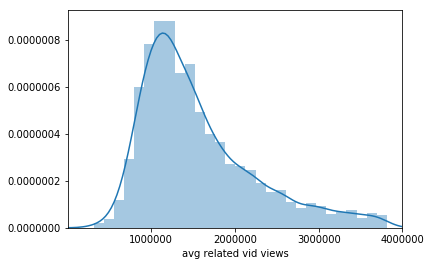

In [158]:
plt.xlim(0, 4000000)
plt.xticks([1000000, 2000000, 3000000, 4000000])
sns.distplot(no_outliers, axlabel="avg related vid views")
plt.savefig('avg_related_vid_views_no_outliers.png')

#### This is also slightly skewed right, and looks very similar to the view distribution without outliers
#### Let's see if there is a correlation between view count and the average number of related views

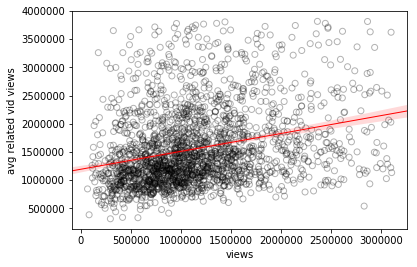

In [140]:
ax = sns.regplot(x=xaxis , y=no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('views_vs_avg_related_vid_views.png')
plt.show()

#### Maybe of order 2?

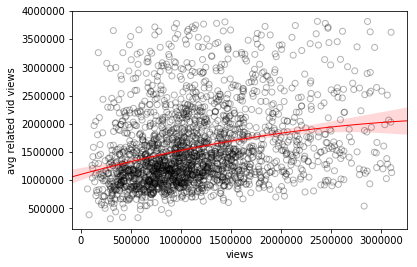

In [139]:
ax = sns.regplot(x=xaxis , y=no_outliers, order=2, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('views_vs_avg_related_vid_views_order_2.png')
plt.show()

#### not different enough to matter. Let's look at the residuals for the linear regression and the slope and $R^2$ scores

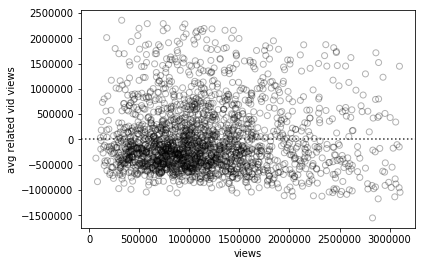

In [138]:
ax = sns.residplot(x=xaxis, y=no_outliers, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('views_vs_avg_related_vid_views_residuals.png')
plt.show()

In [12]:
A = np.vstack([no_outliers, np.ones(len(no_outliers))]).T
b1, b0 = np.linalg.lstsq(A, xaxis)[0]
resid = (np.linalg.lstsq(A, xaxis)[1])[0]
r2 = 1 - resid / (no_outliers.size * no_outliers.var())

print "slope = {0:.5f}".format(b1)
print "R^2   = {0:.5f}".format(r2)

slope = 0.24557
R^2   = 0.28663


#### In short, there is a positive linear correlation between video views and the number of views on related videos, but it is a moderate to weak one.

### Create undirected Graph

In [37]:
undirected_graph = []

for idx, row in df.iterrows():
    for talk in ast.literal_eval(row.related_talks):
        i0 = talk['title']
        i1 = row.title
        # check if extra quotations were added, problem in dataset
        if i0[0] == '"':
            i0 = i0[1:len(i0) - 1]
        if i1[0] == '"':
            i1 = i1[1:len(i1) - 1]
        undirected_graph.append(sorted([i0, i1]))

undirected_graph = list(set(map(tuple,undirected_graph)))

### add column of number of related videos

In [40]:
related_vid_nums = []

for idx, row in df.iterrows():
    total = 0
    for edge in undirected_graph:
        if edge[0] == row.title or edge[1] == row.title:
            total += 1
    related_vid_nums.append(total)

### How do the number of related videos affect view counts?

In [101]:
# add num_related_vids feature
df['num_related_vids'] = pd.Series(data=related_vid_nums)

q1_views = df['views'].quantile(0.25)
q3_views = df['views'].quantile(0.75)
q1_num_related_vids = df['num_related_vids'].quantile(0.25)
q3_num_related_vids = df['num_related_vids'].quantile(0.75)

views_no_outliers = [row.views if row.views < q3_views + (q3_views - q1_views) * 1.5 else np.nan for idx, row in df.iterrows()]
num_related_vids_no_outliers = [row.num_related_vids if row.num_related_vids < q3_num_related_vids + (q3_num_related_vids - q1_num_related_vids) * 1.5 else np.nan for idx, row in df.iterrows()]
num_related_vids_no_outliers = [num_related_vids_no_outliers[idx] if not np.isnan(views_no_outliers[idx]) else np.nan for idx, row in df.iterrows()]
views_no_outliers = [views_no_outliers[idx] if not np.isnan(num_related_vids_no_outliers[idx]) else np.nan for idx, row in df.iterrows()]

for i in range(len(views_no_outliers)-1, -1, -1):
    if np.isnan(views_no_outliers[i]):
        views_no_outliers.pop(i)
        num_related_vids_no_outliers.pop(i)

for i in range(len(num_related_vids_no_outliers)-1, -1, -1):
    if np.isnan(num_related_vids_no_outliers[i]):
        num_related_vids_no_outliers.pop(i)
        views_no_outliers.pop(i)

views_no_outliers = pd.Series(data=views_no_outliers)
num_related_vids_no_outliers = pd.Series(data=num_related_vids_no_outliers)


#### distributions

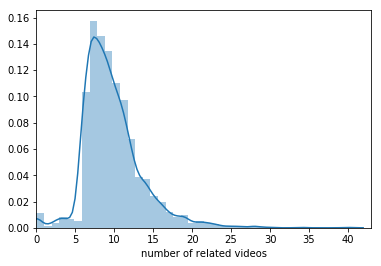

In [134]:
plt.xlim(0, 43)
sns.distplot(df.num_related_vids, bins=41, axlabel='number of related videos')
plt.savefig('num_related_vids_outliers.png')

#### No outliers

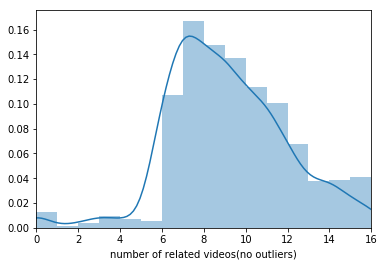

In [135]:
plt.xlim(0, 16)
sns.distplot(num_related_vids_no_outliers, bins=16, axlabel='number of related videos(no outliers)')
plt.savefig('num_related_vids_no_outliers.png')

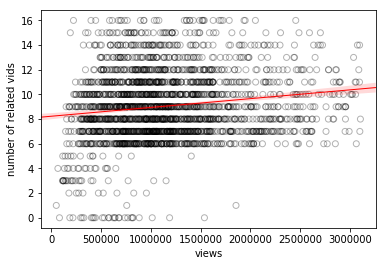

In [137]:
ax = sns.regplot(x=views_no_outliers , y=num_related_vids_no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='number of related vids')
plt.savefig('views_vs_num_related_vids.png')
plt.show()

In [65]:
X = views_no_outliers.reshape(-1, 1)
regr = LinearRegression()
regr.fit(X, num_related_vids_no_outliers)
y_pred = regr.predict(X)

print "slope = {0:.11f}".format(regr.coef_[0])
print "R^2   = {0:.5f}".format(r2_score(num_related_vids_no_outliers, y_pred))

slope = 0.00000071312
R^2   = 0.02334


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
